In [8]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KernelDensity

# The Earth Similarity Index (ESI) Function

$\text{ESI}_x = \left(1 - \frac{|x - x_0|}{|x + x_0|}\right)^w$

In [9]:
def compute_esi(mass, radius, star_temp, star_radius, semi_major_axis, w_radius=0.57, w_density=1.07, w_Escape_velocity= 0.7, w_temp = 5.58, print_values=False):
    """
    Calculate the Earth Similarity Index (ESI) for an exoplanet.
    
    This function computes the ESI based on the methodology described in:
    Schulze-Makuch, Dirk, et al. "A two-tiered approach to assessing the 
    habitability of exoplanets." Astrobiology 11.10 (2011): 1041-1052.
    
    Parameters:
    -----------
    mass : float
        Planet mass in Jupiter masses (M_J)
    radius : float
        Planet radius in Jupiter radii (R_J)
    star_temp : float
        Host star temperature in Kelvin (K)
    star_radius : float
        Host star radius in solar radii (R_☉)
    semi_major_axis : float
        Semi-major axis of the planet's orbit in Astronomical Units (AU)
    w_radius : float, optional
        Weight factor for radius in ESI calculation (default: 0.57)
    w_density : float, optional
        Weight factor for density in ESI calculation (default: 1.07)
    w_Escape_velocity : float, optional
        Weight factor for escape velocity in ESI calculation (default: 0.7)
    w_temp : float, optional
        Weight factor for temperature in ESI calculation (default: 5.58)
    
    Returns:
    --------
    float
        Earth Similarity Index value (between 0 and 1)
    """
    # Conversion factors
    MJ_TO_SI = 1.899e+27     # Jupiter mass to kg
    RJ_TO_SI = 7.149e+7     # Jupiter radius to kg
    AU_TO_SI = 1.496e+11     # AU to meters
    solar_radius_to_si = 6.957e+8 # Solar radius to meters
    G =6.67*10**(-11)

    # Convert to SI units
    mass_e = mass * MJ_TO_SI
    radius_e = radius * RJ_TO_SI
    star_radius_e = star_radius * solar_radius_to_si
    semi_major_axis_e = semi_major_axis * AU_TO_SI

    # Estimate density in SI units:
    density_e = mass_e /((4/3)*np.pi*(radius_e ** 3))
    #Escape velocity
    Escape_velocity = np.sqrt(2*mass_e*G/radius_e)

    # Exoplanet Equilibrium tempertaure calculations
    T_eq = star_temp  * np.sqrt(star_radius_e / (2 * semi_major_axis_e)) * (1-0.3) ** 0.25 + 30 # plus 30 k for Green house effect

    if print_values:
        print(f"mass_e: {mass_e} kg")
        print(f"radius_e: {radius_e:.4} m")
        print(f"density_e: {density_e} kg/m3")
        print(f"Escape_velocity: {Escape_velocity} m/s")
        print(f"Surface temp {T_eq}K")

    # Normalized ESI formula (interior version)
    r_comp = (1 - abs((radius_e - 6.378e+6) / (radius_e + 6.378e+6))) ** w_radius
    d_comp = (1 - abs((density_e - 5532) / (density_e + 5532))) ** w_density
    v_comp = (1 - abs((Escape_velocity - 11186 ) / (Escape_velocity + 11186 ))) ** w_Escape_velocity
    t_comp = (1 - abs((T_eq - 288) / (T_eq + 288))) ** w_temp
    # Calculate ESI
    esi = (r_comp * d_comp * v_comp * t_comp) ** (1 / (w_radius + w_density + w_Escape_velocity + w_temp))
    return esi

# Testing the function for Earth 
print('computing ESI for Earth')
print('--------------------------------------------')
Earth_ESI = compute_esi(0.00314558, 0.0892147, 5770, 1, 1, print_values=True)  # should be very close to 1
print(f"The ESI for Earth is: {Earth_ESI:.4f}") 
print('--------------------------------------------')

# Testing the function for Mars
print('computing ESI for Mars')
print('--------------------------------------------')
Mars_ESI = compute_esi(0.000338065886, 0.03413710625, 5770, 1, 1.524,print_values=True)  # should be less than 1
print(f"The ESI for Mars is: {Mars_ESI:.4f}")
print('--------------------------------------------')

# testing the function for Jupiter
print('computing ESI for Jupiter')
print('--------------------------------------------')
Jupiter_ESI = compute_esi(1, 1, 5770, 1, 5.2, print_values=True)  # should be very low
print(f"The ESI for Jupiter is: {Jupiter_ESI:.4f}")
print('--------------------------------------------')



computing ESI for Earth
--------------------------------------------
mass_e: 5.97345642e+24 kg
radius_e: 6.378e+06 m
density_e: 5496.572248141412 kg/m3
Escape_velocity: 11177.634549471755 m/s
Surface temp 284.4957477096652K
The ESI for Earth is: 0.9952
--------------------------------------------
computing ESI for Mars
--------------------------------------------
mass_e: 6.41987117514e+23 kg
radius_e: 2.44e+06 m
density_e: 10544.395843631057 kg/m3
Escape_velocity: 5923.863884944829 m/s
Surface temp 236.15223460717374K
The ESI for Mars is: 0.8196
--------------------------------------------
computing ESI for Jupiter
--------------------------------------------
mass_e: 1.899e+27 kg
radius_e: 7.149e+07 m
density_e: 1240.7962270763508 kg/m3
Escape_velocity: 59527.51438223392 m/s
Surface temp 141.60376820415019K
The ESI for Jupiter is: 0.5163
--------------------------------------------


# Estimating $f_p$

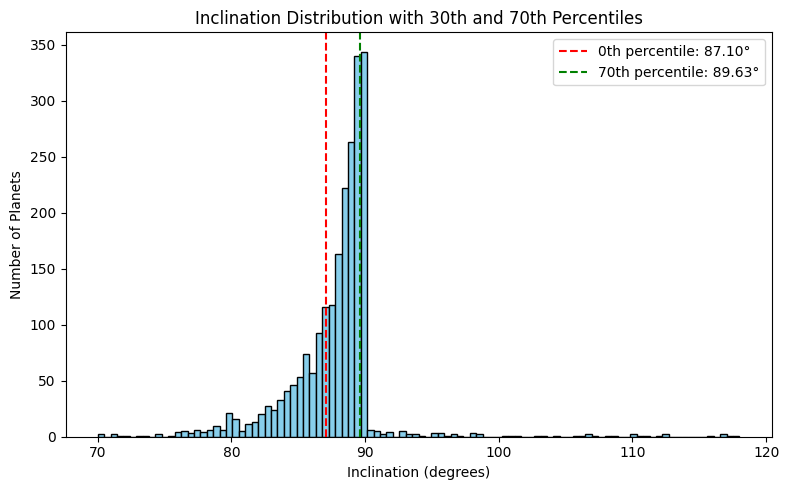

del_i: 2.53 degrees


In [10]:
df = pd.read_csv(r"exoplanet_catalogue.csv") # make sure notebook is in the same directory as the csv file

# Filter inclination values
filtered_incl = df['inclination'][(df['inclination'] >= 70) & (df['inclination'] <= 120)]

# Compute 30th and 70th percentiles
q30 = filtered_incl.quantile(0.3)
q70 = filtered_incl.quantile(0.8)
del_i = q70 - q30
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(filtered_incl, bins=100, color='skyblue', edgecolor='k')
plt.xlabel("Inclination (degrees)")
plt.ylabel("Number of Planets")
plt.title("Inclination Distribution with 30th and 70th Percentiles")

# Add vertical lines for quantiles
plt.axvline(q30, color='red', linestyle='--', label=f'0th percentile: {q30:.2f}°')
plt.axvline(q70, color='green', linestyle='--', label=f'70th percentile: {q70:.2f}°')

# Add legend
plt.legend()

plt.tight_layout()
plt.show()


print(f"del_i: {del_i:.2f} degrees")

## Estimate number of stars with planets

In [11]:
# Total number of stars in the galaxy

N_stars = 2*(10**24) # citation neeeded
allowed_inclination_interval = del_i


# Uniform distribution
pdf = allowed_inclination_interval/180
print(f"The probability that a star has a planet: {pdf:.4f}")
Stars_with_planet_obs = pdf*N_stars
print(f"Stars with planets in the allowed inclination interval: {Stars_with_planet_obs:.2e} stars")


The probability that a star has a planet: 0.0141
Stars with planets in the allowed inclination interval: 2.81e+22 stars


$f_p$ was esitmated to be $0.0141$.  
$f_p * N_{stars} = 2.81e+22$ is the total number stars in the galaxy

## Estimate number of planets in the galaxy

In [12]:
# Group by star_name and calculate required values
results = df.groupby('star_name').agg(
    planet_count=('star_name', 'count'),  # Count planets per star
).reset_index()

Average_planets_in_sol = results['planet_count'].sum()/len(results)
print("Average_Planets", Average_planets_in_sol)
Total_planets = Stars_with_planet_obs * Average_planets_in_sol


print(f"Total Planets in the Galaxy: {Total_planets:.2e}")

Average_Planets 1.3032625786163523
Total Planets in the Galaxy: 3.66e+22


# Finding the distribution of the 5 features

Here we model the joint probability function of 5 features. We utilize a non-parametric methods that is KDE.

We assume the exoplanetary mass-radius distribution, the semi major axis distribution, and the stellar radius-temperature distribution are all independant. This allows us to create a 5D probability density function from these 3 distribtuions by simple multiplication. 

In [13]:
df1 = pd.read_csv(r"exoplanet_catalogue.csv")
df = df1.dropna(subset=['mass','radius','star_teff','semi_major_axis','star_radius']).copy()

# Create log-transformed data for better visualization and modeling
df['log_mass'] = np.log10(df['mass'])
df['log_radius'] = np.log10(df['radius'])
df['log_semi_major_axis'] = np.log10(df['semi_major_axis'])
df['log_star_radius'] = np.log10(df['star_radius'])

# Calculate 5th and 95th percentiles for trimming
lower_bound = df['star_teff'].quantile(0.05)
upper_bound = df['star_teff'].quantile(0.95)

# Filter the DataFrame
df = df[(df['star_teff'] >= lower_bound) & (df['star_teff'] <= upper_bound)].copy()

# Extract the data as numpy arrays for modeling
x1 = df['log_mass'].values
x2 = df['log_radius'].values
x3 = df['star_teff'].values
x4 = df['log_semi_major_axis'].values
x5 = df['log_star_radius'].values

data = np.vstack([x1, x2,x3,x4,x5]).T
x1min, x1max = x1.min(), x1.max()
x2min, x2max = x2.min(), x2.max()
x3min, x3max = x3.min(), x3.max()
x4min, x4max = x4.min(), x4.max()
x5min, x5max = x5.min(), x5.max()

# KDE Approach

Exoplanetary mass-radius distribution

NotImplementedError: 

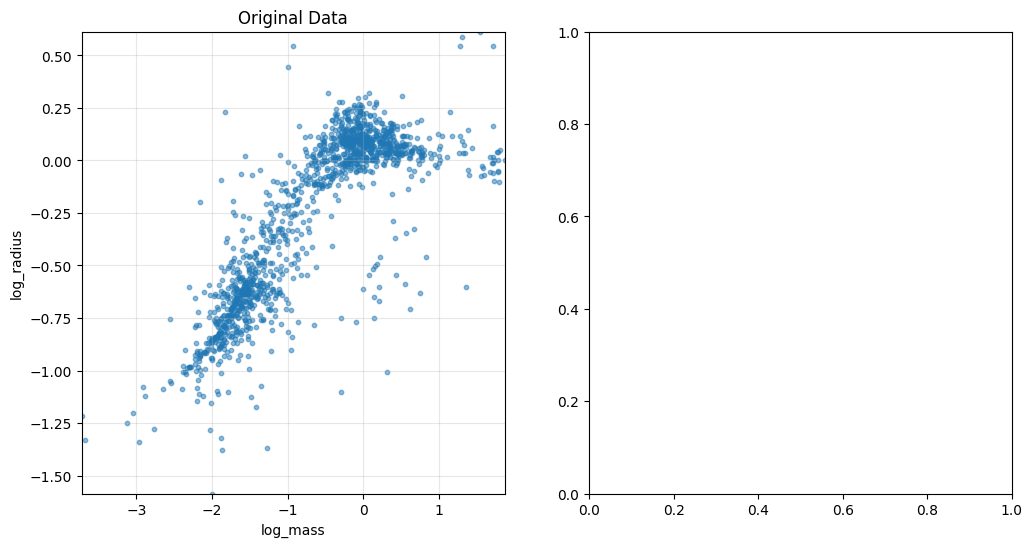

In [14]:

# Create grid of points
X1, X2 = np.mgrid[x1min:x1max:100j, x2min:x2max:100j]
positions = np.vstack([X1.ravel(), X2.ravel()]).T  # Shape (N, 2)

# Stack your data (shape: [n_samples, 2])
data = np.vstack([x1, x2]).T

# Fit KDE with Epanechnikov kernel and Silverman's bandwidth
# (SciPy’s Silverman rule for bandwidth estimation)
n_samples = data.shape[0]
d = data.shape[1]  # Number of dimensions (2)

# Silverman's rule for multivariate data
silverman_factor = (n_samples * (d + 2) / 4.0) ** (-1 / (d + 4))
bandwidth = silverman_factor * np.std(data, axis=0).mean()

exo_mass_radius_kernel = KernelDensity(
    kernel='epanechnikov',
    bandwidth=bandwidth
).fit(data)

# Evaluate log-density on grid points, then exponentiate
log_density = exo_mass_radius_kernel.score_samples(positions)
Z = np.exp(log_density).reshape(X1.shape)

# Determine the common limits for all plots
x_lim = (x1min, x1max)
y_lim = (x2min, x2max)

# Create first figure with 2 subplots
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Original Data Scatter Plot
axs[0].scatter(x1, x2, alpha=0.5, s=10)
axs[0].set_xlabel('log_mass')
axs[0].set_ylabel('log_radius')
axs[0].set_title('Original Data')
axs[0].set_xlim(x_lim)
axs[0].set_ylim(y_lim)
axs[0].grid(True, alpha=0.3)

# Plot 2: Sampled Data from KDE
sample_number = 1000
kde_samples = exo_mass_radius_kernel.sample(sample_number)
axs[1].scatter(kde_samples[0], kde_samples[1], alpha=0.5, s=10, c='green')
axs[1].set_xlabel('log_mass')
axs[1].set_ylabel('log_radius')
axs[1].set_title(f'Samples from KDE ({sample_number} samples)')
axs[1].set_xlim(x_lim)
axs[1].set_ylim(y_lim)
axs[1].grid(True, alpha=0.3)

# Improve layout for first figure
fig1.tight_layout()
# fig1.savefig('kde_samples_comparison.png', dpi=300)

# Create second figure for the filled contour plot
fig2, ax = plt.subplots(figsize=(10, 8))

# Plot: Original data with filled contours
scatter = ax.scatter(x1, x2, alpha=0.5, s=10, label='Original Data')
contourf = ax.contourf(X1, X2, Z, levels=10, cmap='viridis', alpha=0.5)
ax.set_xlabel('log_mass', fontsize=12)
ax.set_ylabel('log_radius', fontsize=12)
ax.set_title('Original Data with KDE Filled Contours', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.legend(fontsize=10)

# Add colorbar
cbar = plt.colorbar(contourf, ax=ax, label='Density')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Density', fontsize=12)

# Improve layout for second figure
fig2.tight_layout()
# fig2.savefig('kde_filled_contours.png', dpi=300)

plt.show()

In [ ]:
stop

Stellar radius-temperature distribtution

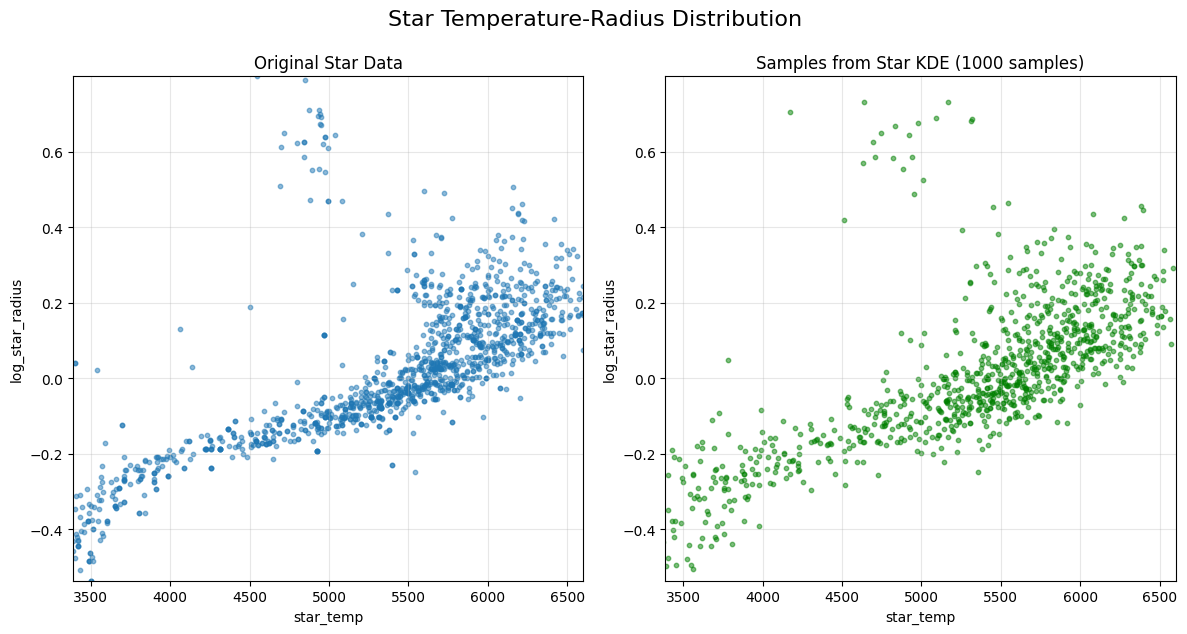

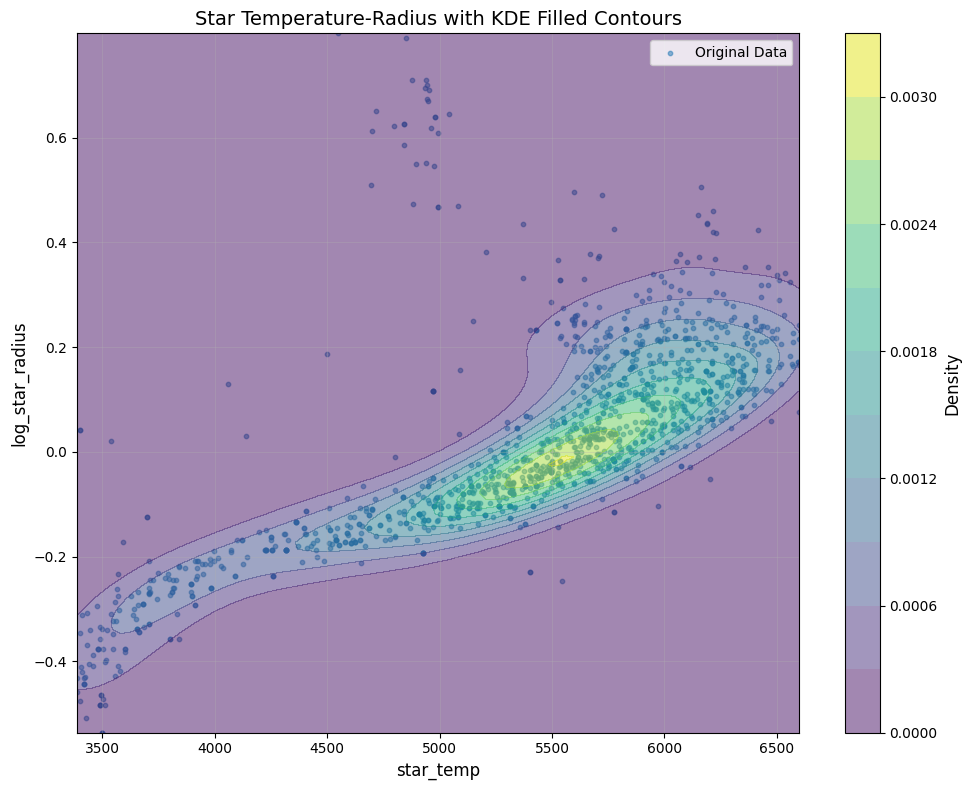

In [ ]:
# Create grid of points
X3, X5 = np.mgrid[x3min:x3max:100j, x5min:x5max:100j]
positions = np.vstack([X3.ravel(), X5.ravel()])
values = np.vstack([x3, x5])

# Compute the KDE
star_radius_temp_kernel = stats.gaussian_kde(values, bw_method='silverman')

# Visualization

# Evaluate KDE on grid
Z_star = star_radius_temp_kernel(positions)
Z_star = Z_star.reshape(X3.shape)

# Determine the common limits for star temp-radius plots
x_lim_star = (x3min, x3max)
y_lim_star = (x5min, x5max)

# Create first figure with 2 subplots for star temp-radius
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Original Data Scatter Plot
axs[0].scatter(x3, x5, alpha=0.5, s=10)
axs[0].set_xlabel('star_temp')
axs[0].set_ylabel('log_star_radius')
axs[0].set_title('Original Star Data')
axs[0].set_xlim(x_lim_star)
axs[0].set_ylim(y_lim_star)
axs[0].grid(True, alpha=0.3)

# Plot 2: Sampled Data from KDE
sample_number = 1000
kde_samples_star = star_radius_temp_kernel.resample(sample_number)
axs[1].scatter(kde_samples_star[0], kde_samples_star[1], alpha=0.5, s=10, c='green')
axs[1].set_xlabel('star_temp')
axs[1].set_ylabel('log_star_radius')
axs[1].set_title(f'Samples from Star KDE ({sample_number} samples)')
axs[1].set_xlim(x_lim_star)
axs[1].set_ylim(y_lim_star)
axs[1].grid(True, alpha=0.3)

# Improve layout for first figure
fig1.tight_layout()
fig1.suptitle('Star Temperature-Radius Distribution', fontsize=16, y=1.05)
# fig1.savefig('star_kde_samples_comparison.png', dpi=300)

# Create second figure for the filled contour plot
fig2, ax = plt.subplots(figsize=(10, 8))

# Plot: Original data with filled contours
scatter = ax.scatter(x3, x5, alpha=0.5, s=10, label='Original Data')
contourf = ax.contourf(X3, X5, Z_star, levels=10, cmap='viridis', alpha=0.5)
ax.set_xlabel('star_temp', fontsize=12)
ax.set_ylabel('log_star_radius', fontsize=12)
ax.set_title('Star Temperature-Radius with KDE Filled Contours', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xlim(x_lim_star)
ax.set_ylim(y_lim_star)
ax.legend(fontsize=10)

# Add colorbar
cbar = plt.colorbar(contourf, ax=ax, label='Density')
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Density', fontsize=12)

# Improve layout for second figure
fig2.tight_layout()

plt.show()

Semi major axis distribution

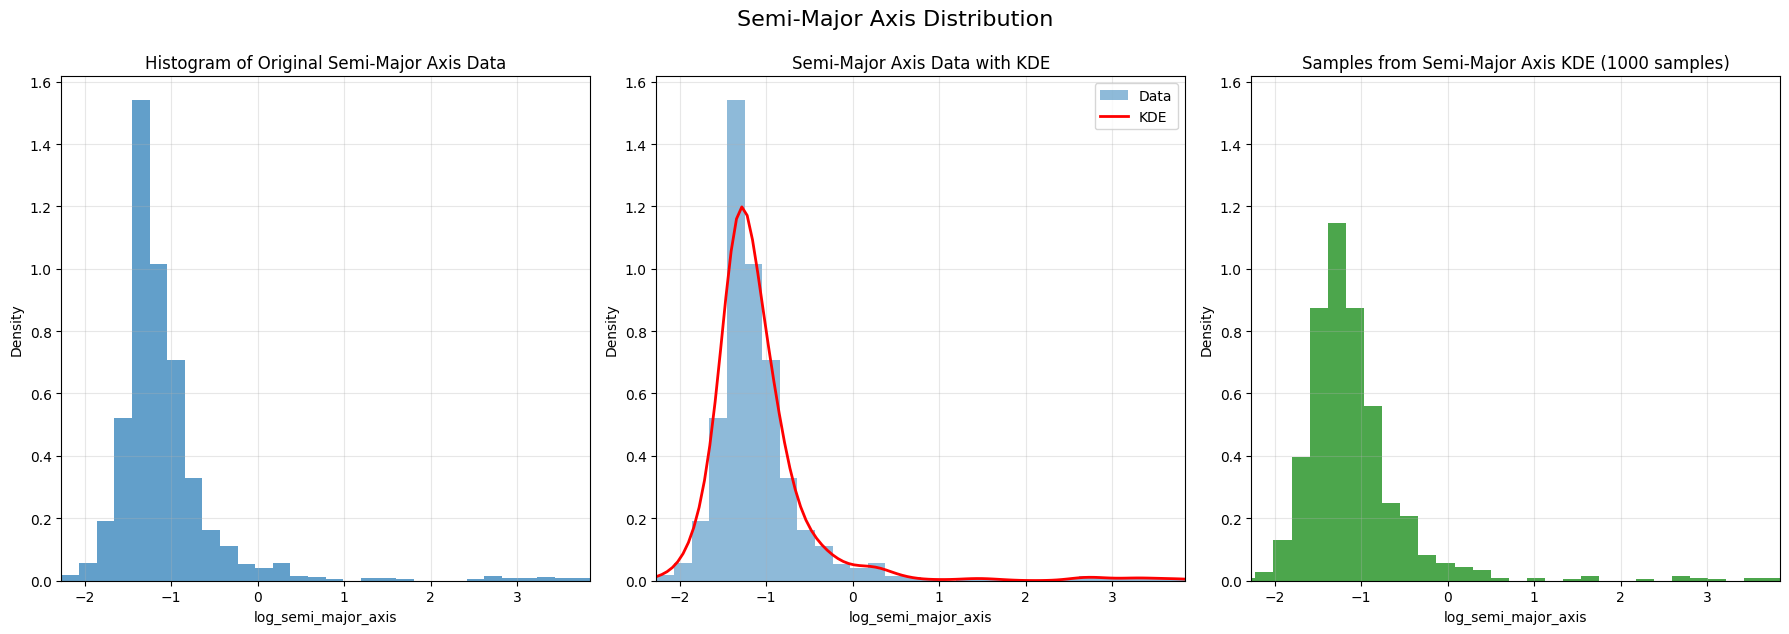

In [ ]:
# Create grid of points
X4 = np.mgrid[x4min:x4max:100j]
positions = np.vstack([X4.ravel()])
values = np.vstack([x4])

# Compute the KDE
sma_kernel = stats.gaussian_kde(values, bw_method='silverman')
# Visualization
# Evaluate KDE on grid
Z_sma = sma_kernel(positions)

# Create figure with 3 subplots for semi-major axis
fig3, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Histogram of original data
axs[0].hist(x4, bins=30, alpha=0.7, density=True)
axs[0].set_xlabel('log_semi_major_axis')
axs[0].set_ylabel('Density')
axs[0].set_title('Histogram of Original Semi-Major Axis Data')
axs[0].grid(True, alpha=0.3)
axs[0].set_xlim(x4min, x4max)

# Plot 2: KDE curve over histogram
axs[1].hist(x4, bins=30, alpha=0.5, density=True, label='Data')
axs[1].plot(X4, Z_sma, 'r-', lw=2, label='KDE')
axs[1].set_xlabel('log_semi_major_axis')
axs[1].set_ylabel('Density')
axs[1].set_title('Semi-Major Axis Data with KDE')
axs[1].grid(True, alpha=0.3)
axs[1].set_xlim(x4min, x4max)
axs[1].legend()

# Plot 3: Sampled Data from KDE as histogram
sample_number = 1000
kde_samples_sma = sma_kernel.resample(sample_number)
axs[2].hist(kde_samples_sma[0], bins=30, alpha=0.7, density=True, color='green')
axs[2].set_xlabel('log_semi_major_axis')
axs[2].set_ylabel('Density')
axs[2].set_title(f'Samples from Semi-Major Axis KDE ({sample_number} samples)')
axs[2].grid(True, alpha=0.3)
axs[2].set_xlim(x4min, x4max)

# Ensure all y-axes have the same scale
y_max = max([ax.get_ylim()[1] for ax in axs])
for ax in axs:
    ax.set_ylim(0, y_max)

# Improve layout for third figure
fig3.tight_layout()
fig3.suptitle('Semi-Major Axis Distribution', fontsize=16, y=1.05)
# fig3.savefig('sma_kde_comparison.png', dpi=300)

plt.show()

# The joint probability density function

Here we assume that the pdf are independant so we can just multiply to obtain the joint pdf

In [ ]:
# reference to set the bounds on the sample function
print(x1min, x1max)
print(x2min, x2max)
print(x3min, x3max)
print(x4min, x4max)
print(x5min, x5max)

-3.721246399047171 1.8656960599160706
-1.585026652029182 0.6127838567197355
3388.0 6600.0
-2.2676062401770314 3.838849090737255
-0.5361070110140927 0.7993405494535817


In [ ]:
def joint_pdf(log_mass,log_radius,star_temp,log_semi_major_axis,log_star_radius):
    z1 = exo_mass_radius_kernel(np.vstack([log_mass, log_radius]))
    z2 = star_radius_temp_kernel(np.vstack([star_temp, log_star_radius]))
    z3 = sma_kernel(log_semi_major_axis)
    return z1 * z2 * z3

def sample_jpdf(n_samples, bounds = 0):
    """
    Sample from the joint PDF of exoplanet and star properties.
    
    Args:
        n_samples: Number of samples to generate
        
    Returns:
        A dictionary containing arrays of sampled values for each parameter
    """
    # Initialize arrays to store samples
    samples = {
        'log_mass': np.zeros(n_samples),
        'log_radius': np.zeros(n_samples),
        'star_temp': np.zeros(n_samples),
        'log_star_radius': np.zeros(n_samples),
        'log_semi_major_axis': np.zeros(n_samples)
    }
    
    # Use rejection sampling to generate samples
    accepted = 0
    attempts = 0
    max_attempts = n_samples * 100000  # Set a maximum to avoid infinite loops
    
    if bounds == 0:
        # Define the bounds for each parameter (adjust based on your data)
        bounds = {
            'log_mass': (-4, 2),         # log(Jupiter masses)
            'log_radius': (-2, 1.5),   # log(Jupiter radii)
            'star_temp': (1000, 20000),  # Kelvin
            'log_semi_major_axis': (-3, 4), # log(AU)
            'log_star_radius': (-5, 1), # log(Solar radii)
        }
    else:
        if type(bounds) != dict:
            raise ValueError("Bounds must be a dictionary.")

    
    # Find approximate max value of joint pdf to improve rejection sampling efficiency
    # This could be improved by using a more sophisticated method to find the true maximum
    test_points = 1000
    max_val = 0
    for _ in range(test_points):
        test_params = {k: np.random.uniform(v[0], v[1]) for k, v in bounds.items()}
        pdf_val = joint_pdf(test_params['log_mass'], test_params['log_radius'], 
                          test_params['star_temp'], test_params['log_semi_major_axis'],
                          test_params['log_star_radius'])
        max_val = max(max_val, pdf_val)
    
    # Apply a safety factor
    max_val *= 1.2
    
    while accepted < n_samples and attempts < max_attempts:
        # Generate random uniform values within bounds
        proposed = {k: np.random.uniform(v[0], v[1]) for k, v in bounds.items()}
        
        # Calculate PDF value at proposed point
        pdf_val = joint_pdf(proposed['log_mass'], proposed['log_radius'], 
                          proposed['star_temp'], proposed['log_semi_major_axis'],
                          proposed['log_star_radius'])
        
        # Accept or reject based on relative probability
        if np.random.uniform(0, max_val) < pdf_val:
            for key in samples:
                samples[key][accepted] = proposed[key]
            accepted += 1
        
        attempts += 1
    
    if attempts >= max_attempts:
        print(f"Warning: Reached maximum attempts ({max_attempts}). Only {accepted} samples were generated.")
        # Trim arrays if we didn't get enough samples
        for key in samples:
            samples[key] = samples[key][:accepted]
    
    return samples    

Use the old definitaion of Earth likeness and give me a range for these 5 features.

We can integrate the joint pdf over this range to give us probability of finding a planet in this range.  
Finally we can multiply this with our total number of planets to get number of Earth like planets.


Sample the joint pdf in this restricted "Earth like" range to get a distribution of planets.  


### 3D Visualization of the 5D space using colour and dot size to denote stellar temperature and radius.

Animation saved as 'original_exoplanet_3d_visualization.gif'


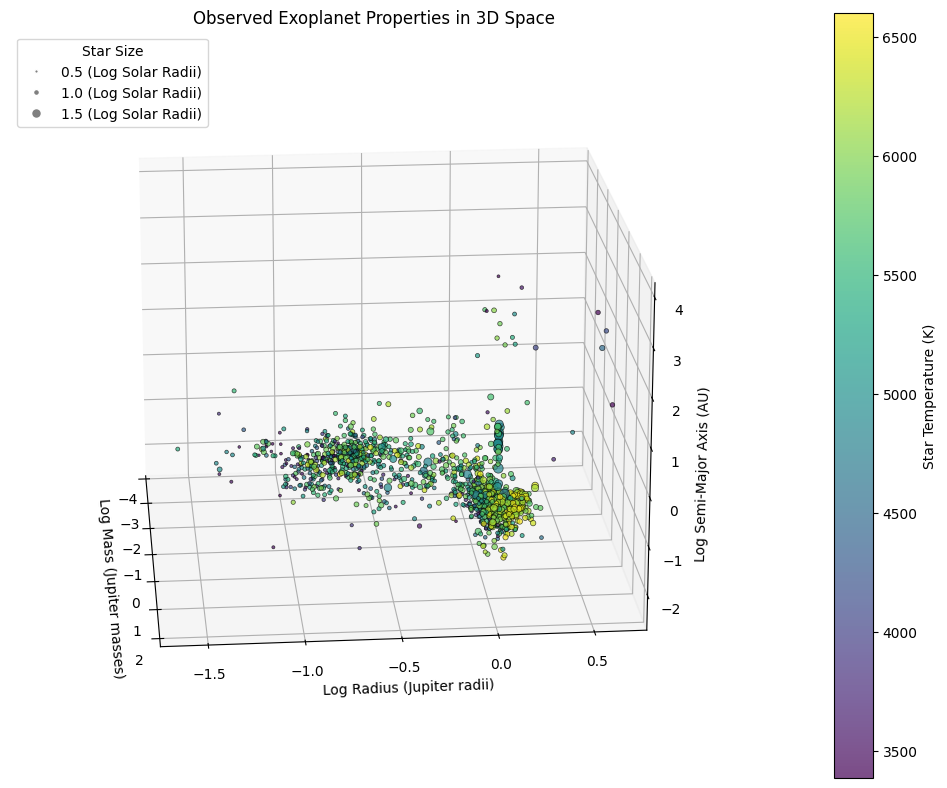

In [ ]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import io
from PIL import Image


# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract data
x =                 x1
y =                 x2
z =                 x4
colors =            x3
sizes = 10 * np.exp(x5 * 2)  # Scale for better visibility

# Create scatter plot
scatter = ax.scatter(
    x, y, z,
    c=colors,
    s=sizes,
    alpha=0.7,
    cmap='viridis',
    edgecolors='black',
    linewidth=0.5
)

# Set labels and title
ax.set_xlabel('Log Mass (Jupiter masses)')
ax.set_ylabel('Log Radius (Jupiter radii)')
ax.set_zlabel('Log Semi-Major Axis (AU)')
ax.set_title('Observed Exoplanet Properties in 3D Space')

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Star Temperature (K)')

# Add a legend for size reference
handles, labels = [], []
for size in [0.5, 1.0, 1.5]:  # Reference values in log solar radii
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                             markersize=np.sqrt(10 * np.exp(size * 2))/2, label=f'{size:.1f}'))
    labels.append(f'{size:.1f} (Log Solar Radii)')
ax.legend(handles, labels, title='Star Size', loc='upper left')

# Function to update plot for animation
def rotate(angle):
    ax.view_init(elev=20 + 10 * np.sin(angle), azim=angle)
    return [scatter]

# Create animation
frames = []
for angle in np.linspace(0, 2*np.pi, 72, endpoint=False):  # 72 frames for 360 degrees
    ax.view_init(elev=20 + 10 * np.sin(angle), azim=angle * 180/np.pi)
    plt.draw()
    
    # Save the current frame to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100)
    buf.seek(0)
    frames.append(Image.open(buf))

# Save as animated GIF
frames[0].save(
    'original_exoplanet_3d_visualization.gif',
    format='GIF',
    append_images=frames[1:],
    save_all=True,
    duration=100,  # milliseconds per frame
    loop=0  # 0 means loop forever
)

print("Animation saved as 'original_exoplanet_3d_visualization.gif'")

# Display the static plot (the GIF will be saved as a file)
plt.tight_layout()
plt.show()

In [ ]:
n_samples = 1000
samples = sample_jpdf(n_samples)

In [ ]:
print(samples.keys())

sample_mass = samples['log_mass']
sample_radius = samples['log_radius']
sample_star_temp = samples['star_temp']
sample_star_radius = samples['log_star_radius']
sample_semi_major_axis = samples['log_semi_major_axis']

dict_keys(['log_mass', 'log_radius', 'star_temp', 'log_star_radius', 'log_semi_major_axis'])


Animation saved as 'KDE_exoplanet_3d_visualization.gif'


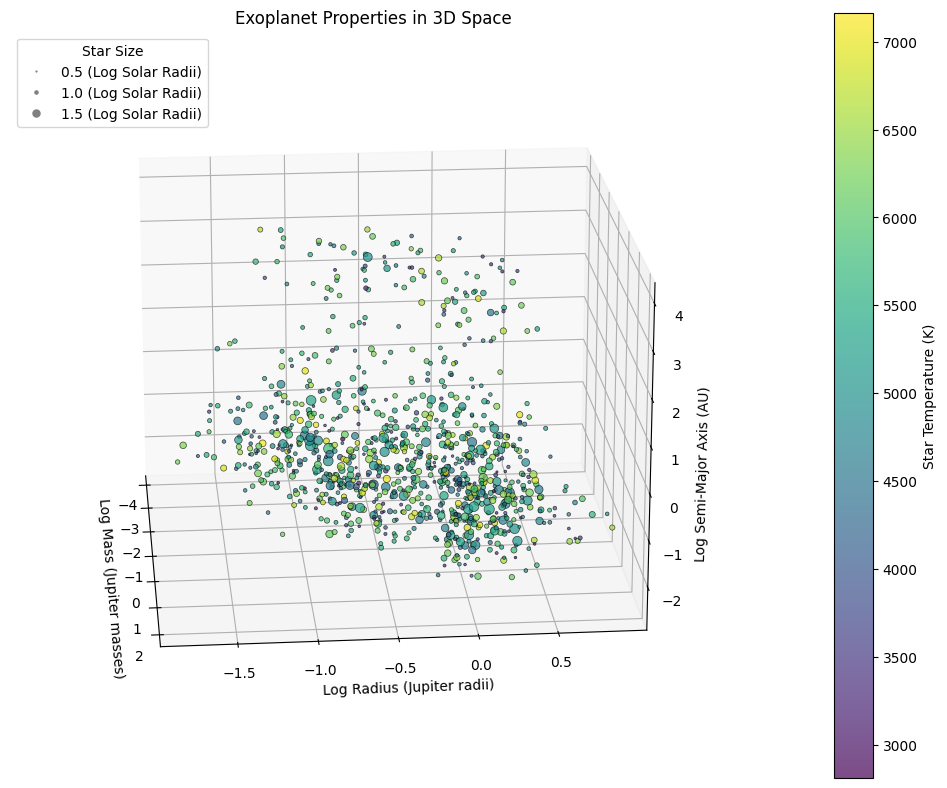

In [ ]:
# Create figure and 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract data
x =                 samples['log_mass']
y =                 samples['log_radius']
z =                 samples['log_semi_major_axis']
colors =            samples['star_temp']
sizes = 10 * np.exp(samples['log_star_radius'] * 2)  # Scale for better visibility

# Create scatter plot
scatter = ax.scatter(
    x, y, z,
    c=colors,
    s=sizes,
    alpha=0.7,
    cmap='viridis',
    edgecolors='black',
    linewidth=0.5
)

# Set labels and title
ax.set_xlabel('Log Mass (Jupiter masses)')
ax.set_ylabel('Log Radius (Jupiter radii)')
ax.set_zlabel('Log Semi-Major Axis (AU)')
ax.set_title('Exoplanet Properties in 3D Space')

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Star Temperature (K)')

# Add a legend for size reference
handles, labels = [], []
for size in [0.5, 1.0, 1.5]:  # Reference values in log solar radii
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                             markersize=np.sqrt(10 * np.exp(size * 2))/2, label=f'{size:.1f}'))
    labels.append(f'{size:.1f} (Log Solar Radii)')
ax.legend(handles, labels, title='Star Size', loc='upper left')

# Function to update plot for animation
def rotate(angle):
    ax.view_init(elev=20 + 10 * np.sin(angle), azim=angle)
    return [scatter]

# Create animation
frames = []
for angle in np.linspace(0, 2*np.pi, 72, endpoint=False):  # 72 frames for 360 degrees
    ax.view_init(elev=20 + 10 * np.sin(angle), azim=angle * 180/np.pi)
    plt.draw()
    
    # Save the current frame to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100)
    buf.seek(0)
    frames.append(Image.open(buf))

# Save as animated GIF
frames[0].save(
    'KDE_exoplanet_3d_visualization.gif',
    format='GIF',
    append_images=frames[1:],
    save_all=True,
    duration=100,  # milliseconds per frame
    loop=0  # 0 means loop forever
)

print("Animation saved as 'KDE_exoplanet_3d_visualization.gif'")

# Display the static plot (the GIF will be saved as a file)
plt.tight_layout()
plt.show()

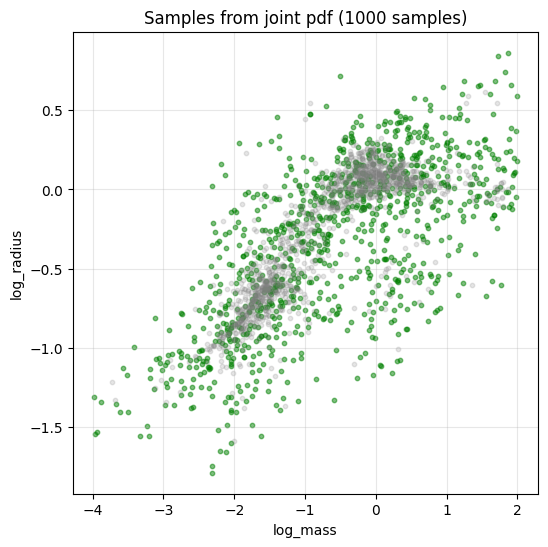

In [ ]:
plt.figure(figsize = (6,6))
plt.scatter(sample_mass, sample_radius, alpha=0.5, s=10, c='green', label='Sampled Data')
plt.scatter(x1, x2, alpha=0.2, s=10, c='grey', label='Original Data')
plt.xlabel('log_mass')
plt.ylabel('log_radius')
plt.title(f'Samples from joint pdf ({len(sample_mass)} samples)')
plt.grid(True, alpha=0.3)

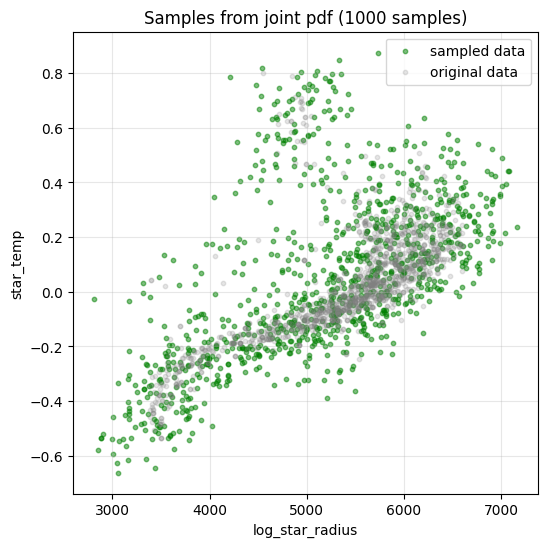

In [ ]:
plt.figure(figsize = (6,6))
plt.scatter( sample_star_temp, sample_star_radius, alpha=0.5, s=10, c='green', label = 'sampled data')
plt.scatter(x3, x5, alpha=0.2, s=10,c = 'grey', label = 'original data')
plt.xlabel('log_star_radius')
plt.ylabel('star_temp')
plt.title(f'Samples from joint pdf ({len(sample_star_temp)} samples)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

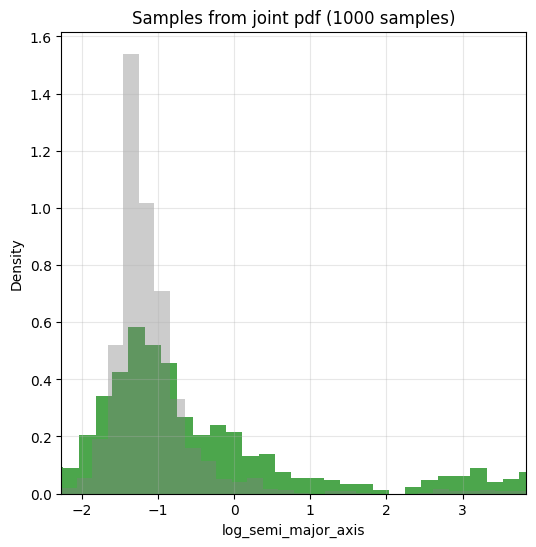

In [ ]:
plt.figure(figsize = (6,6))
plt.hist(sample_semi_major_axis, bins=30, alpha=0.7, density=True, color='green', label='sampled data')
plt.hist(x4, bins=30, alpha=0.4, density=True, color = 'grey', label = 'original data')
plt.xlabel('log_semi_major_axis')
plt.ylabel('Density')
plt.xlim(x4min, x4max)
plt.title(f'Samples from joint pdf ({len(sample_semi_major_axis)} samples)')
plt.grid(True, alpha=0.3)


# Integration to find the probability from the PDF

In [ ]:
np.random.seed(42)  # For reproducibility

def integrate_joint_pdf_qmc(bounds, n_samples=100000):
    """
    Integrate the 5D joint PDF using quasi-Monte Carlo integration with
    low-discrepancy sequences.
    
    Args:
        bounds: Dictionary with parameter bounds in the form:
               {'log_mass': (min, max), 'log_radius': (min, max), etc.}
        n_samples: Number of samples to use
    
    Returns:
        Estimated integral value and its error estimate
    """
    try:
        from scipy.stats import qmc
    except ImportError:
        raise ImportError("This function requires scipy >= 1.7.0 for qmc module")
    
    # Extract bounds for each parameter in the order we'll use
    param_names = ['log_mass', 'log_radius', 'star_temp', 'log_semi_major_axis', 'log_star_radius']
    param_bounds = [bounds[name] for name in param_names]
    
    # Create a low-discrepancy sequence sampler (Sobol sequence)
    sampler = qmc.Sobol(d=5, scramble=True)
    
    # Generate samples in the unit hypercube [0, 1]^5
    unit_samples = sampler.random(n_samples)
    
    # Scale samples to the desired bounds
    l_bounds = np.array([b[0] for b in param_bounds])
    u_bounds = np.array([b[1] for b in param_bounds])
    samples = qmc.scale(unit_samples, l_bounds, u_bounds)
    
    # Calculate volume of the integration region
    volume = np.prod(u_bounds - l_bounds)
    
    # Evaluate the joint PDF at these points
    pdf_values = joint_pdf(samples[:, 0], samples[:, 1], samples[:, 2], samples[:, 3], samples[:, 4])
    
    # Compute the integral estimate
    integral_estimate = np.mean(pdf_values) * volume
    
    # Error estimation for QMC is more complex than standard MC
    # We'll use a simple approximation by dividing the samples into batches
    n_batches = 20
    batch_size = n_samples // n_batches
    batch_results = np.zeros(n_batches)
    
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        batch_values = pdf_values[start_idx:end_idx]
        batch_results[i] = np.mean(batch_values) * volume
    
    error_estimate = np.std(batch_results, ddof=1) / np.sqrt(n_batches)
    
    return integral_estimate, error_estimate

def integrate_joint_pdf_adaptive(bounds, n_initial=10000, max_samples=1000000, 
                                target_error=1e-3, max_iterations=10):
    """
    Integrate the 5D joint PDF using adaptive Monte Carlo integration.
    Increases samples until desired precision is reached or max samples used.
    
    Args:
        bounds: Dictionary with parameter bounds
        n_initial: Initial number of samples
        max_samples: Maximum number of samples to use
        target_error: Target relative error
        max_iterations: Maximum number of iterations for adaptive sampling
    
    Returns:
        Dict with integral estimate, error, and number of samples used
    """
    # Extract bounds for each parameter
    log_mass_bounds = bounds['log_mass']
    log_radius_bounds = bounds['log_radius']
    star_temp_bounds = bounds['star_temp']
    log_semi_major_axis_bounds = bounds['log_semi_major_axis']
    log_star_radius_bounds = bounds['log_star_radius']
    
    # Calculate volume of the integration region
    volume = ((log_mass_bounds[1] - log_mass_bounds[0]) * 
              (log_radius_bounds[1] - log_radius_bounds[0]) * 
              (star_temp_bounds[1] - star_temp_bounds[0]) * 
              (log_semi_major_axis_bounds[1] - log_semi_major_axis_bounds[0]) * 
              (log_star_radius_bounds[1] - log_star_radius_bounds[0]))
    
    total_samples = 0
    sum_f = 0
    sum_f_squared = 0
    
    for iteration in range(max_iterations):
        # Number of new samples to add in this iteration
        if iteration == 0:
            n_samples = n_initial
        else:
            n_samples = min(total_samples * 2, max_samples - total_samples)
            if n_samples <= 0:
                break
        
        # Generate random uniform samples within the bounds
        log_mass_samples = np.random.uniform(log_mass_bounds[0], log_mass_bounds[1], n_samples)
        log_radius_samples = np.random.uniform(log_radius_bounds[0], log_radius_bounds[1], n_samples)
        star_temp_samples = np.random.uniform(star_temp_bounds[0], star_temp_bounds[1], n_samples)
        log_semi_major_axis_samples = np.random.uniform(log_semi_major_axis_bounds[0], log_semi_major_axis_bounds[1], n_samples)
        log_star_radius_samples = np.random.uniform(log_star_radius_bounds[0], log_star_radius_bounds[1], n_samples)
        
        # Evaluate the joint PDF at these points
        pdf_values = joint_pdf(log_mass_samples, log_radius_samples, star_temp_samples, 
                              log_semi_major_axis_samples, log_star_radius_samples)
        
        # Update running sums
        sum_f += np.sum(pdf_values)
        sum_f_squared += np.sum(pdf_values**2)
        total_samples += n_samples
        
        # Calculate current estimate and error
        mean = sum_f / total_samples
        variance = (sum_f_squared / total_samples - mean**2) / (total_samples - 1) if total_samples > 1 else 0
        std_error = np.sqrt(variance / total_samples) if variance > 0 else 0
        
        integral_estimate = mean * volume
        error_estimate = std_error * volume
        
        # Check if we've reached target error or max samples
        relative_error = error_estimate / abs(integral_estimate) if integral_estimate != 0 else float('inf')
        if relative_error <= target_error or total_samples >= max_samples:
            break
    
    return {
        'integral': integral_estimate,
        'error': error_estimate,
        'relative_error': relative_error,
        'samples_used': total_samples
    }

### Finding the value of the pdf integrated over all the 5D space, should be close to 1.

In [ ]:
# entire space
bounds = {
    'log_mass': (-4, 2),            # log(Jupiter masses)
    'log_radius': (-2, 1.5),        # log(Jupiter radii)
    'star_temp': (1000, 35000),     # Kelvin
    'log_semi_major_axis': (-3, 4), # log(AU)
    'log_star_radius': (-5, 1),     # log(Solar radii)
}

print('Entire space')

# Using QMC integration
result, error = integrate_joint_pdf_qmc(bounds, n_samples=500000)
print(f"QMC Integration: {result:.6e} ± {error:.6e}")

# Using adaptive MC integration
result = integrate_joint_pdf_adaptive(bounds, target_error=1e-4)
print(f"Adaptive Integration: {result['integral']:.6e} ± {result['error']:.6e}")

Entire space


c:\Users\arpan\miniconda3\lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


QMC Integration: 1.145236e+00 ± 1.916791e-01
Adaptive Integration: 9.400654e-01 ± 9.998711e-05


### Finding the probability that a planet will fall into the "Earth Like" cateogry given our pdf using a range. 

This is based on the citations and provides a broad range for Earth like planets. We add a little padding to make sure to catch outliers as well.

In [ ]:
# Earth-like space
EL_bounds = {
    'log_mass': (np.log10(0.00157279), np.log10(0.0157279)),   # 0.5 to 5 Earth masses
    'log_radius': (np.log10(0.0446073), np.log10(0.133822)),   # 0.5 to 1.5 Earth radii
    'star_temp': (4800, 6300)                              ,   # 4800 to 6300 K
    'log_semi_major_axis': (np.log10(0.95), np.log10(1.37)),   # 0.95 to 1.37 AU
    'log_star_radius': (np.log10(0.8), np.log10(1.2))      ,   # 0.8 to 1.2 solar radius
}

def pad_bounds(bounds_dict, padding_factor=0.1):
    padded_dict = {}
    
    for key, (lower, upper) in bounds_dict.items():
        range_val = upper - lower
        padding = range_val * padding_factor
        padded_lower = lower - padding
        padded_upper = upper + padding
        
        # Store in new dictionary
        padded_dict[key] = (padded_lower, padded_upper)
    
    return padded_dict

EL_bounds = pad_bounds(EL_bounds, padding_factor=1)
print('Earth like')

# Using QMC integration
result, error = integrate_joint_pdf_qmc(EL_bounds, n_samples=500000)
print(f"QMC Integration: {result:.6e} ± {error:.6e}")

# Using adaptive MC integration
result = integrate_joint_pdf_adaptive(EL_bounds, target_error=1e-4)
print(f"Adaptive Integration: {result['integral']:.6e} ± {result['error']:.6e}")


number_EL_samples = 10000
EL_samples = sample_jpdf(number_EL_samples, bounds=EL_bounds)

ESIs = []
for i in range(len(EL_samples['log_mass'])):
    mass = 10**(EL_samples['log_mass'][i])
    radius = 10**(EL_samples['log_radius'][i])
    star_temp = EL_samples['star_temp'][i]
    star_radius = 10**(EL_samples['log_star_radius'][i])
    semi_major_axis = 10**(EL_samples['log_semi_major_axis'][i])
    ESI = compute_esi(mass, radius, star_temp, star_radius, semi_major_axis)
    ESIs.append(ESI)

ESI80 = [i for i in ESIs if i > 0.8]
print(len(ESIs))
print(len(ESI80))

prob_ESI80 = len(ESI80)/len(ESIs)
print(f"The probability that the ESI is greater than 0.8 given the Earth-like bounds specified is {prob_ESI80:.4f}")
print(f"The probability that the planet falls within the given Earth-like bounds is {result['integral']:.4e}")
print(f"The probability that the planet has ESI > 0.8 is {result['integral'] * prob_ESI80:.4e}")

# Total_planets from earlier analysis
number_ESI80_planets = Total_planets * result['integral'] * prob_ESI80

print(f"number of planets with ESI > 0.8 is {number_ESI80_planets:.4e}")

Earth like
QMC Integration: 7.443509e-03 ± 2.049879e-05
Adaptive Integration: 7.370943e-03 ± 4.233648e-07
10000
5322
The probability that the ESI is greater than 0.8 given the Earth-like bounds specified is 0.5322
The probability that the planet falls within the given Earth-like bounds is 7.3709e-03
The probability that the planet has ESI > 0.8 is 3.9228e-03
number of planets with ESI > 0.8 is 1.4372e+20
